In [2]:
import torch
from FiretraceMLP import FiretraceMLP

checkpoint = torch.load("../../models/firetrace_model.pt")

model = FiretraceMLP(width=checkpoint['model_size'][0], depth=checkpoint['model_size'][1])
compiled_model = torch.compile(model, fullgraph=True, mode="max-autotune")

compiled_model.load_state_dict(checkpoint['model_state_dict'])
compiled_model.eval()

OptimizedModule(
  (_orig_mod): FiretraceMLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=120, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=120, out_features=120, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=120, out_features=120, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=120, out_features=120, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Linear(in_features=120, out_features=1, bias=True)
    )
  )
)

In [3]:
import pandas as pd

df = pd.read_csv("../../data/gen_2/processed/with_fire_area_soi_weather_time.csv")

# Pick last x rows
df = df.tail(3500)

y = df["fire_area"]
y = y.reset_index()["fire_area"]
X = df.drop("fire_area", axis=1)

In [4]:
import joblib

x_scaler = joblib.load("../../models/x_scaler.save")
y_scaler = joblib.load("../../models/y_scaler.save")

x_scaled = x_scaler.transform(X)

In [5]:
print(x_scaled[0].shape)

(9,)


In [6]:
individual_output = compiled_model(torch.tensor(x_scaled[70], dtype=torch.float32).reshape(1, -1))
individual_output_unscaled = y_scaler.inverse_transform(individual_output.detach().numpy().reshape(1, -1))

print("Predicted fire area: ", individual_output_unscaled)

print("Actual fire area: ", y[70])

Predicted fire area:  [[315.42078]]
Actual fire area:  417.2


In [7]:
test_output = compiled_model(torch.tensor(x_scaled, dtype=torch.float32))

test_output

tensor([[ 0.0132],
        [ 0.0114],
        [ 0.0102],
        ...,
        [-0.0027],
        [ 0.0002],
        [-0.0067]], grad_fn=<CompiledFunctionBackward>)

In [8]:
# Unscale the output

y_unscaled = y_scaler.inverse_transform(test_output.detach().numpy())

y_unscaled

array([[175.75613 ],
       [151.6163  ],
       [136.37321 ],
       ...,
       [-34.41652 ],
       [  3.329324],
       [-87.839554]], dtype=float32)

In [9]:
# Calculate MAE

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, y_unscaled)

233.99133592576536

Text(0, 0.5, 'Fire Area (sqkm)')

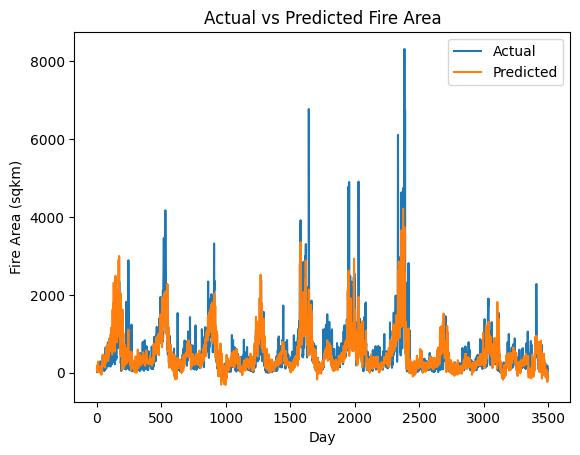

In [10]:
# Graph output vs actual

import matplotlib.pyplot as plt

plt.plot(y, label="Actual")
plt.plot(y_unscaled, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Fire Area")
plt.xlabel("Day")
plt.ylabel("Fire Area (sqkm)")

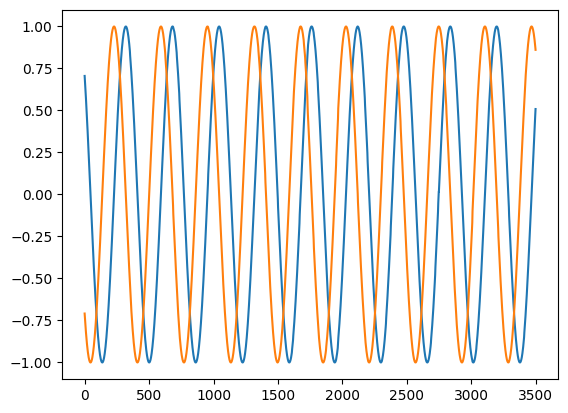

In [11]:
plt.plot(X['sin_signal'].to_numpy())
plt.plot(X['cos_signal'].to_numpy())

